In [1]:
import os
import pickle
from PIL import Image
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.links.caffe import CaffeFunction

from matplotlib import pylab as plt

# モデルの読み込み
https://github.com/BVLC/caffe/tree/master/models/bvlc_googlenet

In [2]:
%%time
MODEL = 'model/bvlc_googlenet.caffemodel'
PICKLE = 'model/ggnet.pkl'
if os.path.exists(PICKLE):
    print("Load pickle")
    with open(PICKLE, 'rb') as pkl:
        model = pickle.load(pkl)
else:
    print("Load caffemodel and make pickle")
    if os.path.exists(MODEL):
        model = CaffeFunction(MODEL)
        with open(PICKLE, 'wb') as pkl:
            pickle.dump(model, pkl)
    print(MODEL + " not found.")

Load pickle
CPU times: user 63.4 ms, sys: 65.7 ms, total: 129 ms
Wall time: 129 ms


In [18]:
class GoogLeNet(Chain):
    insize = 224
    
    def __init__(self):
        super(GoogLeNet, self).__init__()
        with self.init_scope():
            self.conv1 =  L.Convolution2D(3, 64, 7, stride=2, pad=3)
            self.conv2_reduce = L.Convolution2D(64, 64, 1)
            self.conv2 = L.Convolution2D(64, 192, 3, stride=1, pad=1)
            self.inception_3a = L.Inception(192, 64, 96, 128, 16, 32, 32)
            self.inception_3b = L.Inception(256, 128, 128, 192, 32, 96, 64)
            self.inception_4a = L.Inception(480, 192, 96, 208, 16, 48, 64)
            self.inception_4b = L.Inception(512, 160, 112, 224, 24, 64, 64)
            self.inception_4c = L.Inception(512, 128, 128, 256, 24, 64, 64)
            self.inception_4d = L.Inception(512, 112, 144, 288, 32, 64, 64)
            self.inception_4e = L.Inception(528, 256, 160, 320, 32, 128, 128)
            self.inception_5a = L.Inception(832, 256, 160, 320, 32, 128, 128)
            self.inception_5b = L.Inception(832, 384, 192, 384, 48, 128, 128)
            loss3_fc = L.Linear(1024, 1000)
            
            loss1_conv = L.Convolution2D(512, 128, 1)
            loss1_fc1 = L.Linear(2048, 1024)
            loss1_fc2 = L.Linear(1024, 1000)
            
            loss2_conv = L.Convolution2D(528, 128, 1)
            loss2_fc1 = L.Linear(2048, 1024)
            loss2_fc2 = L.Linear(1024, 1000)
        
    def __call__(self, x, train=True):
        h = F.relu(self.conv1(x))
        h = F.max_pooling_2d(h, 3, stride=2)
        h = F.local_response_normalization(h, n=5, k=1, alpha=2e-05)
        h = F.relu(self.conv2_reduce(h))
        h = F.relu(self.conv2(h))
        h = F.local_response_normalization(h, n=5, k=1, alpha=2e-05)
        h = F.max_pooling_2d(h, 3, stride=2)
        
        h = self.inception_3a(h)
        h = self.inception_3b(h)
        h = F.max_pooling_2d(h, 3, stride=2)
        h = self.inception_4a(h)
        
        l = F.average_pooling_2d(h, 5, stride=3)
        l = F.relu(self.loss1_conv(l))
        l = F.relu(self.loss1_fc1(l))
        l = self.loss1_fc2(l)
        
        h = self.inception_4b(h)
        h = self.inception_4c(h)
        h = self.inception_4d(h)
        
        l = F.average_pooling_2d(h, 5, stride=3)
        l = F.relu(self.loss2_conv(l))
        l = F.relu(self.loss2_fc1(l))
        l = self.loss2_fc2(l)
        
        h = self.inception_4e(h)
        h = F.max_pooling_2d(h, 3, stride=2)
        h = self.inception_5a(h)
        h = self.inception_5b(h)
        
        h = F.average_pooling_2d(h, 7, stride=1)
        y = self.loss3_fc(F.dropout(h, 0.4, train=train))
        return y

In [19]:
ggn = GoogLeNet()

# 平均画像を用意する

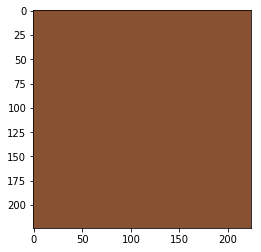

In [3]:
mean_image = np.ndarray((3, 224, 224), dtype=np.float32)
mean_image[0] = 103.939
mean_image[1] = 116.779
mean_image[2] = 123.68
plt.imshow(mean_image.transpose(1,2,0))
plt.show()

# 画像を確認する

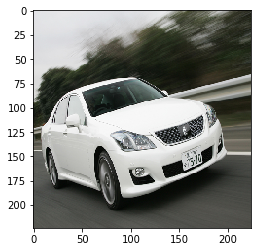

In [4]:
img = Image.open('datas/003.jpg').convert('RGB')
resize_img = img.resize((224,224))
plt.imshow( resize_img )
plt.show()

# 画像をモデルに入れる準備をする

In [5]:
npar_img = np.asarray(resize_img, dtype=np.float32).reshape(224,224,3)
npar_img = npar_img[:,:,::-1]
X = npar_img.transpose(2,0,1)
X = X-mean_image
X = X.reshape(1,3,224,224)

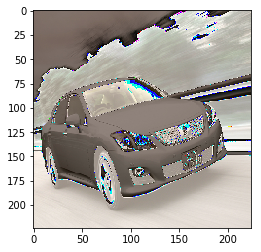

In [6]:
V = np.asarray(X[0], dtype=np.uint8).transpose(1,2,0)
plt.imshow(V)
plt.show()

# モデルに適用する

In [7]:
y, = model(inputs={'data': X}, outputs=['loss3/classifier'])
prediction = F.softmax(y)
np.argmax(prediction.data[0])

817

In [8]:
prediction.data[0,np.argmax(prediction.data)]*100

42.684751749038696